This notebook tests the basic detectron2 model which was trained on the PubLayNet dataset. After realizing that it needs finetuning, some training is done on a colab notebook.

In [1]:
# PubLayNet

In [1]:
import pickle
import torch, torchvision
import detectron2
# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from cv2 import imshow
import argparse
import glob
import multiprocessing as mp
import time
import cv2
import tqdm
from PIL import Image
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
# setup_logger()

from DetectronUtils import VisualizationDemo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import pytesseract


In [2]:
#image example for network to run
INPUT_IMAGE = 'Detectron2LayoutAnalysisInput/00000002.tif'
OUTPUT_IMAGE = 'Detectron2LayoutAnalysisOutput/430_00000002'

In [3]:
# im = cv2.imread("/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/3408/00000002.tif")
# cv2.imshow("test", im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [4]:
#getting basic configuration of detectron
cfg = get_cfg()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.WEIGHTS = "../PubLayNet/faster_rcnn_pre.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

AssertionError: Checkpoint ../PubLayNet/faster_rcnn_pre.pkl not found!

The pretrained model on PubLayNet is a detectron1 model which is deprecated and cannot be used. We use a detectron2 model in the rest of the notebook.

In [5]:
#getting the configuration for detectron2
cfg = get_cfg()
cfg.merge_from_file('/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_config/DLA_mask_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.WEIGHTS = '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_models/resnet50/model_final_trimmed.pth'
cfg.freeze()
model = build_model(cfg)
DetectionCheckpointer(model).load('/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_models/resnet50/model_final_trimmed.pth')

# demo = VisualizationDemo(cfg)
# predictions, visualized_output = demo.run_on_image(img)
# visualized_output.save('Detectron2LayoutAnalysisOutput/3408_00000002')

Config '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_config/DLA_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


{}

In [6]:
#trying out predictor and looking at results
predictor = DefaultPredictor(cfg)
demo = VisualizationDemo(cfg)
img = read_image(INPUT_IMAGE, format="BGR")
predictor(img)
predictions, visualized_output = demo.run_on_image(img)
visualized_output.save(OUTPUT_IMAGE)

/Users/andrealphonse/anaconda/envs/patentproj/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


{'instances': Instances(num_instances=9, image_height=3408, image_width=2320, fields=[pred_boxes: Boxes(tensor([[1033.3822, 1248.9969, 1912.0005, 2352.1814],
        [  95.7315,  747.8304, 1000.6043, 2889.4153],
        [1041.4563,  865.7707, 1913.6776, 1241.2017],
        [ 583.3497,  579.3830, 1474.2889,  620.3672],
        [ 262.7442,  651.4052, 1802.4966,  742.6196],
        [1024.5992, 2360.8174, 1891.3093, 2719.5195],
        [ 261.4338,  439.4074, 1862.9451,  540.9216],
        [ 475.7341,  776.7150, 1575.2456,  817.6176],
        [ 172.7761,  850.0250,  697.5615,  901.2408]])), scores: tensor([0.9690, 0.9667, 0.9562, 0.9173, 0.8939, 0.8029, 0.7372, 0.7008, 0.5341]), pred_classes: tensor([0, 2, 0, 0, 0, 0, 1, 0, 0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
    

Now that we applied the network on the example image, we examine what each instance looks like.

In [8]:
#class dictionnary to analyze instances
class_dict = {0: 'text',1: 'title',2: 'list', 3: 'table', 4: 'figure'}

In [43]:
#getting instances detected on image
instances = []
for i in range(len(predictions['instances'])):
    instances.append({'pred_box': predictions['instances'].pred_boxes[i][0].tensor[0],
                     'score': predictions['instances'].scores[i],
                     'pred_mask': predictions['instances'].pred_masks[i],
                     'pred_class': class_dict[predictions['instances'].pred_classes[i].item()]})

In [10]:
#examining on instance and isolating it with a mask
test_mask = predictions['instances'][3].get_fields()['pred_masks'][0]

In [14]:
import cv2
import numpy as np
image = np.asarray(img,  np.float32)
mask=cv2.cvtColor(np.float32(test_mask),cv2.COLOR_GRAY2BGR)
# Mask input image with binary mask
result = cv2.bitwise_or(image, mask)
# Color background white
result[mask==0] = 0

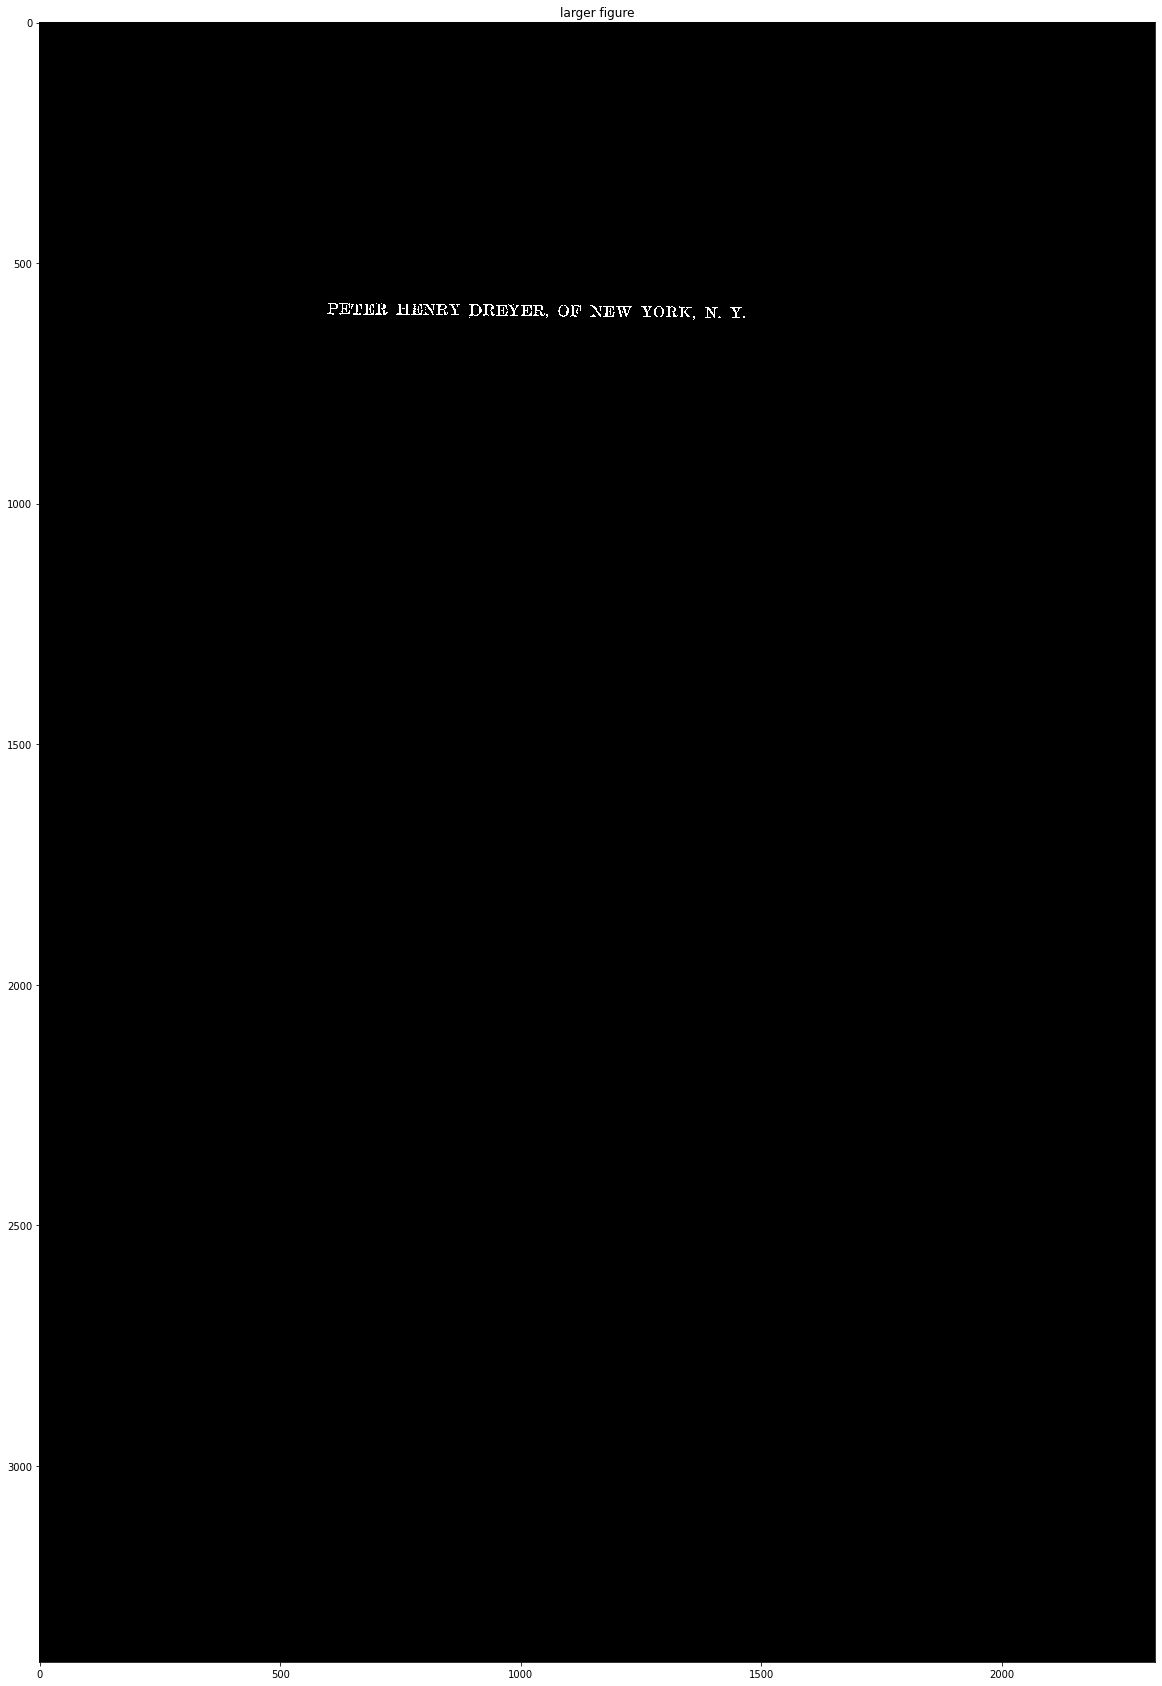

In [16]:
from matplotlib import pyplot as plt
# change the figure size
fig = plt.figure(figsize = (20,40))
ax = fig.add_subplot(111)
ax.imshow(result, interpolation='none')
ax.set_title('larger figure')
plt.show()

In [17]:
def OCR_img(img):
    """
    function to perform OCR on a given image
    Args:
    img - the image to OCR
    Return:
    str_from_img - a string of the recognized text in the image
    """
    str_from_img = pytesseract.image_to_string(img)
    return str_from_img

In [18]:
result.shape

(3408, 2320, 3)

In [19]:
type(Image.fromarray(result.astype(np.uint8)))

PIL.Image.Image

In [20]:
OCR_img(Image.fromarray(result.astype(np.uint8)))

'PHTER HENRY DREYER, OF NEW YORK, N. Y.\n\x0c'

In [27]:
#isolating instances with bounding boxes rather than with masks
test_box = predictions['instances'][3].get_fields()['pred_boxes'][0].tensor[0]

In [37]:
x1, y1, x2, y2 = np.array(test_box)

In [38]:
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) 

In [39]:
result=img[y1:y2,x1:x2]

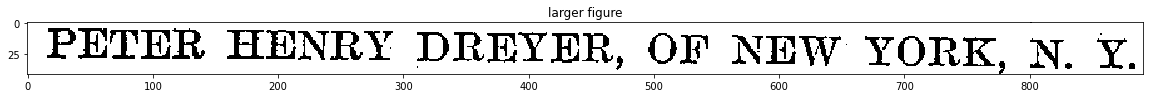

In [40]:
from matplotlib import pyplot as plt
# change the figure size
fig = plt.figure(figsize = (20,40)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.imshow(result, interpolation='none')
ax.set_title('larger figure')

plt.show()

# plt.imshow(image, interpolation='none')
# plt.show()

In [41]:
#better result as OCR is trained for black text on white background
OCR_img(Image.fromarray(result.astype(np.uint8)))

'PETER HENRY DREYER, OF NEW YORK, N. Y.\n\x0c'

In [42]:
# use bounding boxes rather than masks

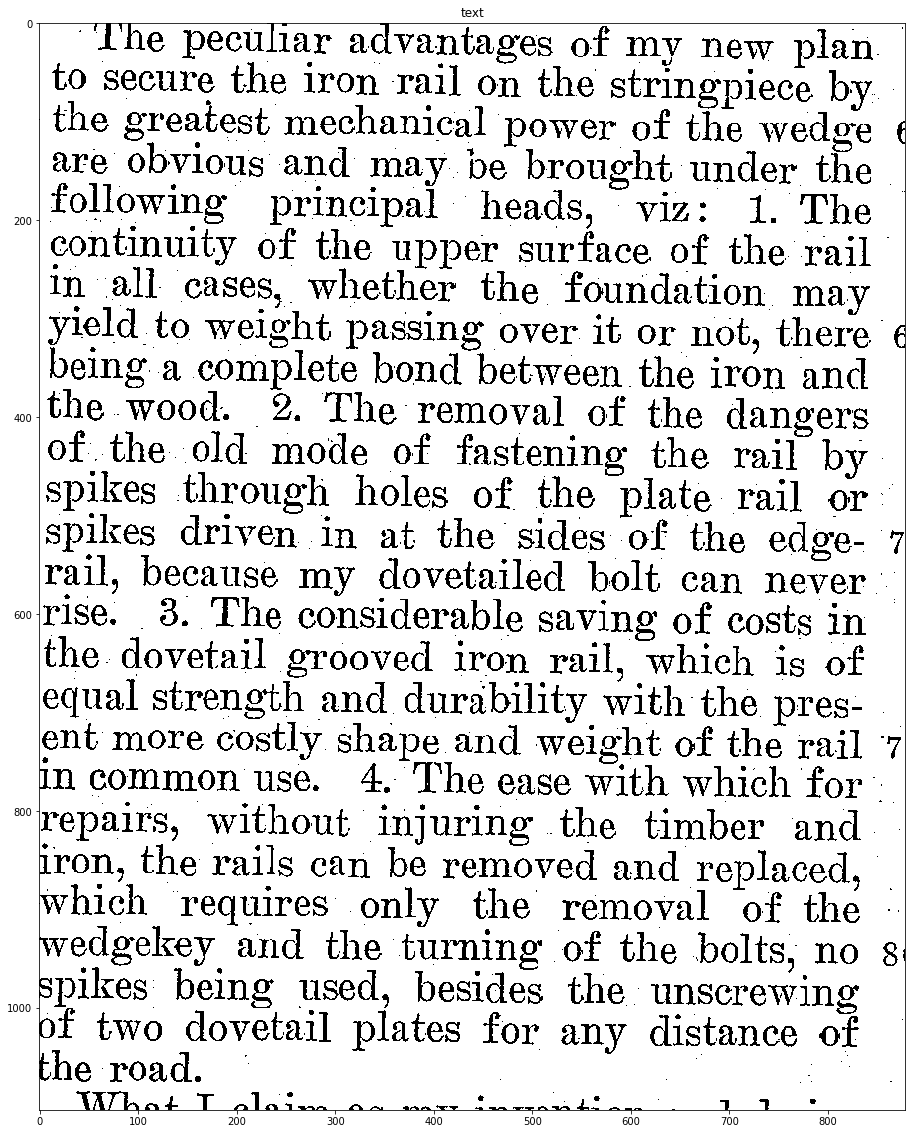

“tne peculiar advantages of my new plan
to secure the iron rail on the stringpiece by
the greatest mechanical power of the wedge
are obvious and may be brought under the
following principal heads, viz: 1. The
continuity of the upper surface of the rail
in all cases, whether the foundation may
yield to weight passing over it or not, there
being a complete bond between the iron and
the wood. 2. The removal of the dangers
of. the old mode of fastening the rail by

spikes through holes of the plate rail or:

spikes driven in at the sides of the edge-
rail, because my dovetailed bolt can never
rise. 3. The considerable saving of costs in
the dovetail grooved iron rail, which is of
equal strength and durability with the pres-

ent more costly shape and weight of the rail -
in common use. 4. The ease with which for -

repairs, without injuring the timber and

—

€

7

x

iron, the rails can be removed and replaced, |
which requires only the removal of the -

wedgekey and the turning of the bo

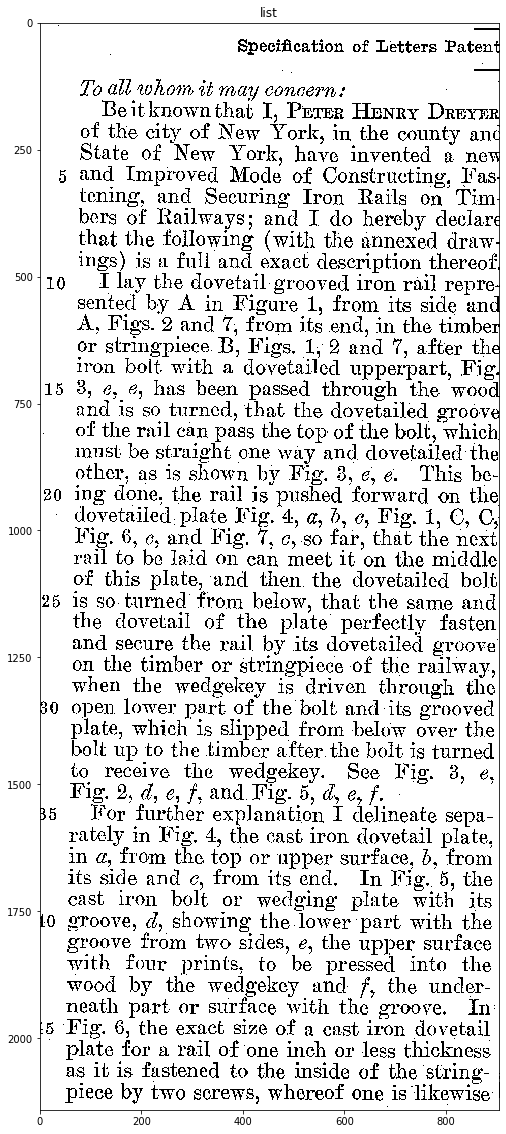

ao

2

or

30

LD

Specification of Letters Patent
To all whom tt may concern:

Beit known that I, Perer Henry Dreyer
of the city of New York, in the county anc
State of New York, have invented a new
and Improved Mode of Constructing, Fas
tening, and Securing Iron Rails on Tim.
bers of Railways; and I do hereby declare
that the following (with the annexed draw-
ings) is a full and exact description thereof

J lay the dovetail-grooved iron rail repre-
sented by A in Figure 1, from its side and
A, Figs. 2 and 7, from its end, in the timber
or stringpiece. B, Figs. 1, 2 and 7, after the
iron bolt with a dovetailed upperpart, Fig.
3, ¢, é, has been passed through the wood
and is so turned, that the dovetailed groove
of the rail can pass the top of the bolt, which
must be straight one way and dovetailed the
other, as is shown by Fig. 8, ¢, e. This be-
ing done, the rail is pushed forward on the
dovetailed plate Fig. 4, a, b, c, Fig. 1, C, C,
Fig. 6, c, and Fig. 7, ¢, so far, that the next
r

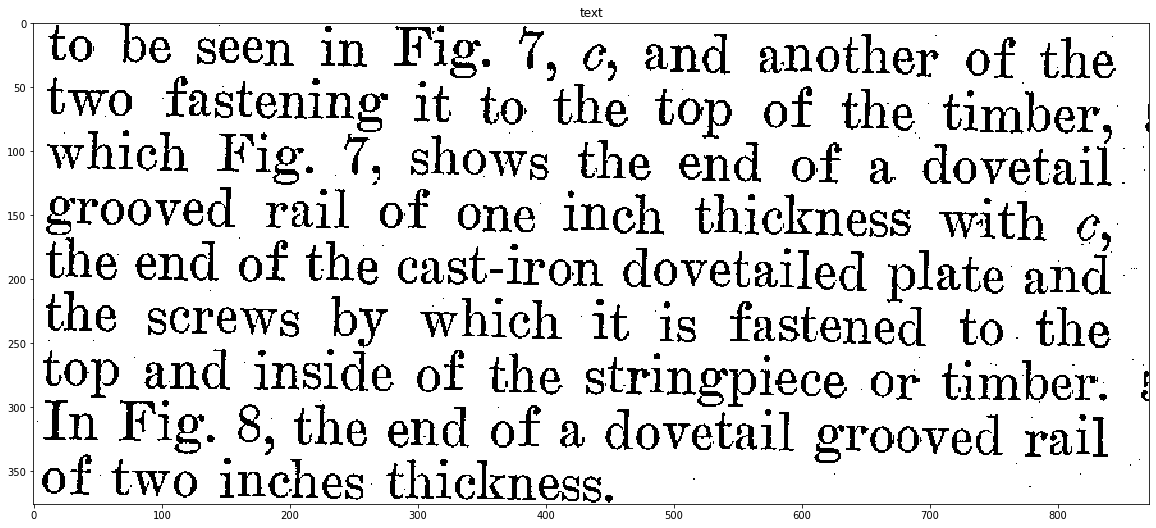

to be seen in Fig. 7, c, and another of the

two fastening it to the top of the timber, |

which Fig. 7, shows the end of a dovetail
grooved rail of one inch thickness with ¢,
the end of the cast-iron dovetailed plate and
the screws by which it is fastened to. the
top and inside of the stringpiece or timber.
In Fig. 8, the end of a dovetail grooved rail
of two inches. thickness,



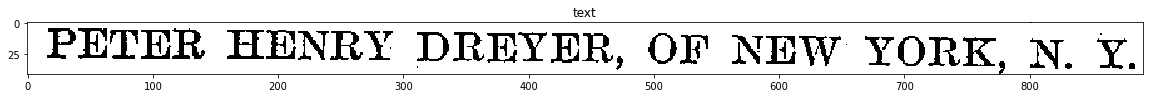

PETER HENRY DREYER, OF NEW YORK, N. Y.



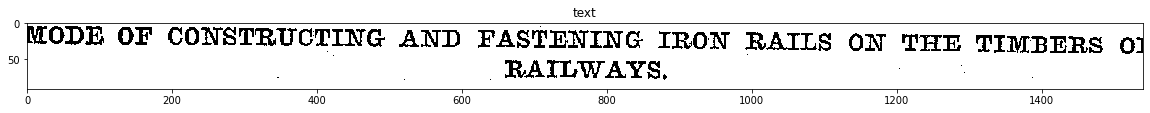

MODE OF CONSTRUCTING AND FASTENING IRON RAILS ON THE TIMBERS 01
RAILWAYS,



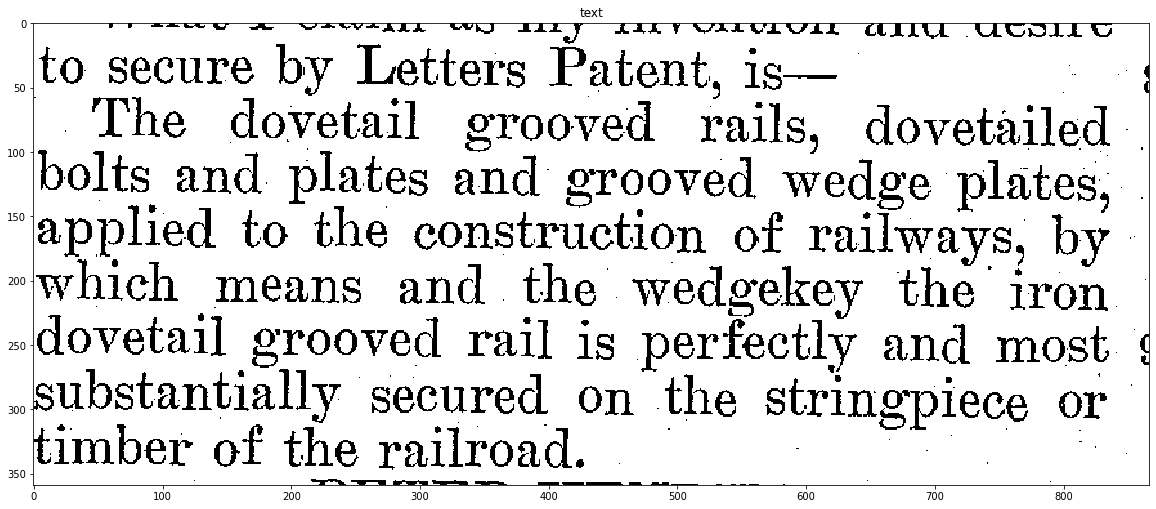

BE I EIEIO RE IMA ARG RARE MARE NANAER CALIA MADLY
to secure by Letters Patent, is—

The dovetail grooved rails, dovetailed
bolts and. plates and grooved wedge plates,
applied to the construction of railways, by
which means and the wedgekey the iron
dovetail grooved rail is perfectly and most
substantially secured on the stringpiece or
timber of the railroad.

r
‘

—_



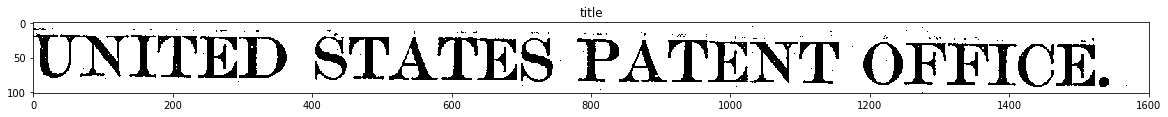

UNITED STATES PATENT OFFICE.



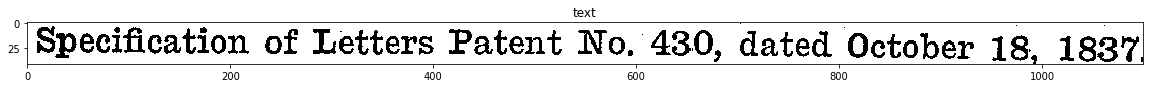

Specification of Letters Patent No. 430, dated October 18, 1837



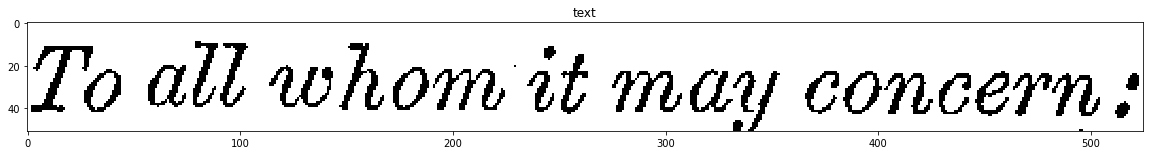

To all whom it may concern:



In [47]:
#printing each instance, its class and OCR done it
for i in range(len(instances)):
#     print(instance[i]['pred_class'])
    x1, y1, x2, y2 = np.array(instances[i]['pred_box'])
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) 
    result=img[y1:y2,x1:x2]
    fig = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    ax.imshow(result, interpolation='none')
    ax.set_title(instances[i]['pred_class'])

    plt.show()
    print(OCR_img(Image.fromarray(result.astype(np.uint8))))

We can see that the results are not very accurate and that some finetuning is needed. Hence we finetune the detectron2 model which was trained on PubLayNet data on annotated patent data.

DATASET NEEDS TO BE IN FOLLOWING FORMAT (JSON):
* input as "images" containing list of dictionnaries (each dict = one image):
    * each dictionnary should contain: file_name, height, width, id
    * e.g.: [{"file_name": "PMC5491943_00004.jpg", "height": 794, "id": 348952, "width": 596}
* output as "annotations" containing list of disctionnaries (each dict = one segmented object):
    * each dictionnary should contain: segmentation (list of polygon coordinates contained in object), area,
    iscrowd (0), image_id (the id of the image in which there is the object), bbox (bounding box coords), category_id, id.
    * e.g. {"segmentation": [[37.59,360.34,288.66,360.34,37.59,360.34]],
      "area": 10218.471181684348,
      "iscrowd": 0,
      "image_id": 346767,
      "bbox": [
        37.59,
        360.34,
        251.07,
        41.36
      ],
      "category_id": 1,
      "id": 3377124
    },

In [3]:
#loading and examining some of the train set images
import json

with open('/Volumes/Non-Backup_Files/GB-patents/json/coco_data_for_model_reduced.json') as json_file:
    coco_data_reduced = json.load(json_file)

In [4]:
for d in ['train']:
    DatasetCatalog.register("patents_train",lambda d=d: coco_data_reduced)
    MetadataCatalog.get("patents_train").set(thing_classes=['text', 'title', 'list', 'table', 'figure', 'sigil'])
    patents_metadata = MetadataCatalog.get("patents_train")

In [14]:
from cv2 import imshow
dataset_dicts = coco_data_reduced
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=patents_metadata)#, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
#     cv2.imshow(out.get_image()[:, :, ::-1])

{'annotations': [{'segmentation': [[149, 244, 1227, 244, 1227, 1935, 149, 1935, 149, 244]], 'bbox': [149, 244, 1227, 1935], 'category_id': 0, 'bbox_mode': 0}, {'segmentation': [[167, 106, 1225, 106, 1225, 230, 167, 230, 167, 106]], 'bbox': [167, 106, 1225, 230], 'category_id': 1, 'bbox_mode': 0}], 'file_name': '/Volumes/Non-Backup_Files/GB-patents/data_for_model/GB184711625A/5.png', 'image_id': 1803, 'width': 1424, 'height': 2137}
{'annotations': [{'segmentation': [[213, 104, 1254, 104, 1254, 268, 213, 268, 213, 104]], 'bbox': [213, 104, 1254, 268], 'category_id': 1, 'bbox_mode': 0}, {'segmentation': [[204, 277, 1254, 277, 1254, 1870, 204, 1870, 204, 277]], 'bbox': [204, 277, 1254, 1870], 'category_id': 0, 'bbox_mode': 0}], 'file_name': '/Volumes/Non-Backup_Files/GB-patents/data_for_model/GB185700283A/6.png', 'image_id': 2275, 'width': 1430, 'height': 2169}
{'annotations': [{'segmentation': [[192, 221, 1223, 221, 1223, 1912, 192, 1912, 192, 221]], 'bbox': [192, 221, 1223, 1912], 'categ

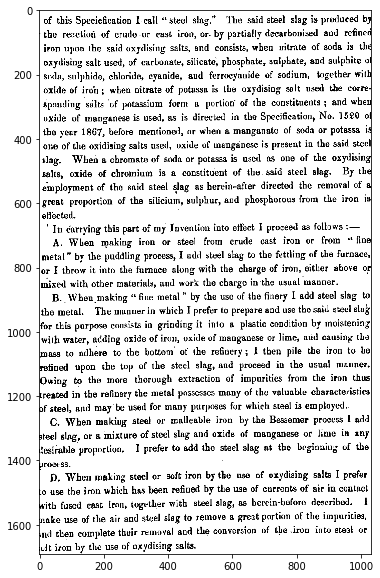

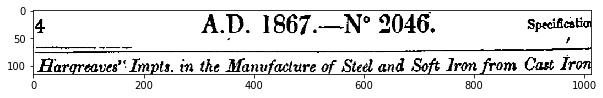

In [15]:
import matplotlib.pyplot as plt
for i in d['annotations']:
    x1, y1, x2, y2 = i['bbox']
    result=img[y1:y2,x1:x2]
    fig = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    ax.imshow(result, interpolation='none')
#     ax.set_title(instances[i]['pred_class'])

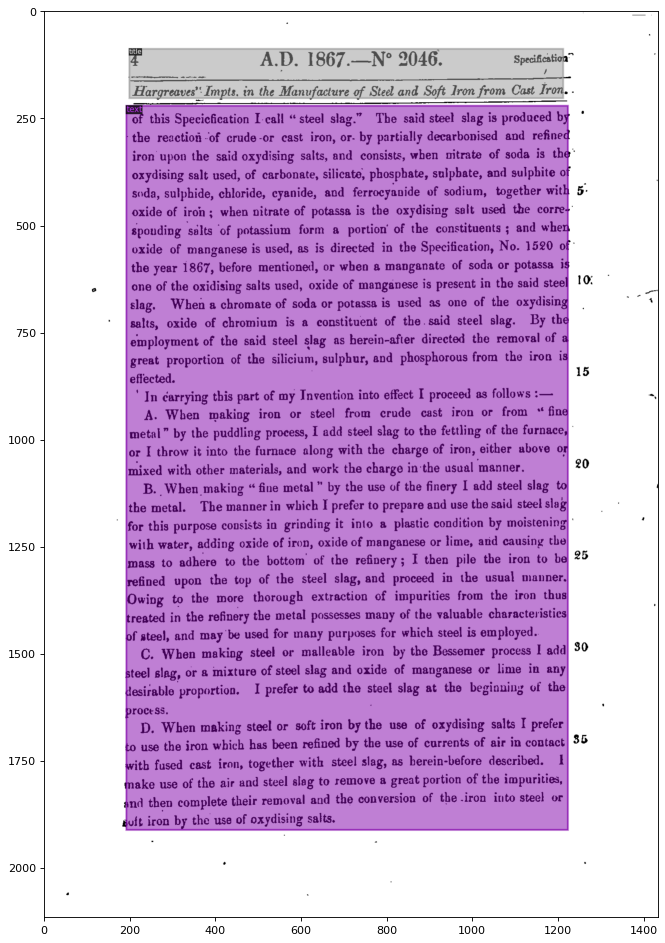

In [16]:
plt.figure(num=None, figsize=(18, 15), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(out.get_image()[:, :, ::-1])

#### First Training Trial Offline

In [23]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("patents2_test", {}, '/Volumes/Non-Backup_Files/GB-patents/json/data_for_model_reduced.json', '/Volumes/Non-Backup_Files/GB-patents/data_for_model')

In [4]:
def get_patent_dicts(d):
    if d == 'train':
        with open('/content/drive/MyDrive/PatentProject/json/coco_data_for_model_reduced_train.json') as json_file:
            coco_data_reduced_train = json.load(json_file)
    # for i in range(len(coco_data_reduced_train)):
    #   coco_data_reduced_train[i]['file_name'] = '/'.join(coco_data_reduced_train[i]['file_name'].split('/')[-3:])
        return coco_data_reduced_train
    elif d == 'train_wh':
        with open('/content/drive/MyDrive/PatentProject/json/coco_data_for_model_reduced_train_wh.json') as json_file:
            coco_data_reduced_train = json.load(json_file)
    # for i in range(len(coco_data_reduced_train)):
    #   coco_data_reduced_train[i]['file_name'] = '/'.join(coco_data_reduced_train[i]['file_name'].split('/')[-3:])
        return coco_data_reduced_train
    elif d == 'test_wh':
        with open('/content/drive/MyDrive/PatentProject/json/coco_data_for_model_reduced_test_wh.json') as json_file:
            coco_data_reduced_test = json.load(json_file)
    # for i in range(len(coco_data_reduced_test)):
    #   coco_data_reduced_test[i]['file_name'] = '/'.join(coco_data_reduced_test[i]['file_name'].split('/')[-3:])
        return coco_data_reduced_test   
    else:
        with open('/content/drive/MyDrive/PatentProject/json/coco_data_for_model_reduced_test.json') as json_file:
            coco_data_reduced_test = json.load(json_file)
    # for i in range(len(coco_data_reduced_test)):
    #   coco_data_reduced_test[i]['file_name'] = '/'.join(coco_data_reduced_test[i]['file_name'].split('/')[-3:])
        return coco_data_reduced_test   

In [9]:
# for d in ['test']:
#     DatasetCatalog.register("patents_" + d,lambda d=d: get_patent_dicts(d))
#     MetadataCatalog.get("patents_" + d).set(thing_classes=['text', 'title', 'list', 'table', 'figure'])
patents_metadata = MetadataCatalog.get("patents_test")

In [11]:
patents_metadata

namespace(name='patents_test',
          json_file='/Volumes/Non-Backup_Files/GB-patents/json/coco_data_for_model_reduced.json',
          image_root='/Volumes/Non-Backup_Files/GB-patents/data_for_model',
          evaluator_type='coco')

In [ ]:
# from detectron2.engine import DefaultTrainer
# cfg = get_cfg()
# cfg.DATASETS.TRAIN = ("patents_train",)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [24]:
cfg = get_cfg()
cfg.merge_from_file('/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_config/DLA_mask_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.DEVICE = 'cpu'
cfg.DATASETS.TEST = ("patents2_test", )
cfg.MODEL.WEIGHTS = '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/finetuned_detectron2/resnet50/model_final.pth'
cfg.freeze()
model = build_model(cfg)
DetectionCheckpointer(model).load('/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/finetuned_detectron2/resnet50/model_final.pth')

# demo = VisualizationDemo(cfg)
# predictions, visualized_output = demo.run_on_image(img)
# visualized_output.save('Detectron2LayoutAnalysisOutput/3408_00000002')

Config '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_config/DLA_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


{'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[-2.7609e-04]],
    
             [[-5.1417e-04]],
    
             [[-6.7714e-05]],
    
             ...,
    
             [[-1.4896e-04]],
    
             [[-3.5563e-04]],
    
             [[-4.4273e-04]]],
    
    
            [[[ 4.3996e-04]],
    
             [[ 1.2098e-03]],
    
             [[ 3.5448e-04]],
    
             ...,
    
             [[ 1.5452e-04]],
    
             [[ 7.3990e-04]],
    
             [[ 3.8605e-04]]],
    
    
            [[[ 2.8189e-05]],
    
             [[ 1.0585e-04]],
    
             [[-4.9108e-04]],
    
             ...,
    
             [[-1.1181e-04]],
    
             [[-3.3179e-04]],
    
             [[ 1.3153e-04]]],
    
    
            ...,
    
    
            [[[-3.8503e-04]],
    
             [[-1.6237e-03]],
    
             [[-6.1168e-04]],
    
             ...,
    
             [[-3.3197e-04]],
    
             [[-5.7634e-04]],
    
             [

In [25]:
cfg.DATASETS.TEST

('patents2_test',)

In [19]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
# cfg.DATASETS.TEST = ("patents_test", )
predictor = DefaultPredictor(cfg)

In [30]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("patents2_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "patents2_test")
print(inference_on_dataset = buit(model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

KeyError: 'categories'

The error encountered prompted me to create two separate datasets as needed for evaluation by the detectron2 evaluator. The evaluator failed to work and evaluation was outsourced i.e. an external library was used.

In [ ]:
im = cv2.imread('gdrive/My Drive/Colab Notebooks/baseball_detection/test/1.png')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
  metadata=ball_metadata,
  scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])